## Setting

### Optional

In [24]:
!pip install xgboost lightgbm catboost -U

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
root = "/content/drive/MyDrive/Machine Learning/"
import sys
sys.path.append(root)

### Required

In [27]:
from close.train_tuning import Model
from close.evaluation import show_confusion_matrix, per_class_accuracy, overall_metrics, top_k_accuracy, confidence_analysis

is_binary = False

## Loading Data

In [28]:
import pickle
import pandas as pd

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"{root}data/preprocess_data_33/close_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y"]
with open(f"{root}data/preprocess_data_33/close_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = val["feature_names"]
    y_val = val["y"]

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 13300
Validation data size:	 2850


## Model

lightGBM

In [29]:
model_type = "lgb"
param_grid = {
    "n_estimators": [100, 200],      # 2
    "max_depth": [5, 10],            # 2
    "learning_rate": [0.1],          # 1
    "subsample": [1.0],              # 1
    "colsample_bytree": [1.0]        # 1
}


### Base Model Training

In [30]:
# 1) LightGBM으로 중요도 계산
mdl = Model(is_binary=is_binary, code="lgb")
mdl.create_model("lgb")
mdl.fit(X_train, y_train)

fi_sorted = mdl.get_feature_importances()
ranked_names = list(fi_sorted.keys())

# 2) top-k 피처 조합 생성
def make_feature_combinations(ranked_names, k_list):
    combos = []
    for k in k_list:
        combos.append({
            "k": k,
            "features": ranked_names[:k]
        })
    return combos

k_list = [24, 29, 33]
feature_combinations = make_feature_combinations(ranked_names, k_list)

print(feature_combinations)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [31]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

results = []

for comb in feature_combinations:        # e.g. k=,24,29,33
    k = comb["k"]
    feat_names = comb["features"]

    print(f"\n====== Testing feature subset: k={k} ======")
    print("Features:", feat_names)

    # 1) 조합에 맞게 subset 생성
    X_train_sub = X_train[feat_names]
    X_val_sub   = X_val[feat_names]

    # 2) 모델 생성 (baseline hyperparameters 사용)
    model = Model(is_binary=is_binary)
    model.create_model(model_type)      # <-- baseline default hparams 자동 적용
    print("Using baseline hparams:", model.hparams)

    # 3) 학습
    model.fit(X_train_sub, y_train)

    # 4) 성능 평가
    val_acc = model.score(X_val_sub, y_val)
    print(f"[k={k}] Val Accuracy = {val_acc:.4f}")

    # 5) K-Fold (train subset 기준)
    cv_scores = model.k_fold_cv(X_train_sub, y_train, k=5)

    # 6) 결과 저장
    results.append({
        "k": k,
        "features": feat_names,
        "val_acc": val_acc,
        "cv_mean": np.mean(cv_scores),
        "cv_scores": cv_scores.tolist(),
    })

# 7) 전체 결과 표로 확인
results_df = pd.DataFrame(results).sort_values(by="val_acc", ascending=False)
print("\n=== Summary (baseline hparams, feature subsets) ===")
print(results_df)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Feature Evaluation

In [32]:
mdl.get_feature_importances()

{np.str_('burst_std_first30'): 941,
 np.str_('duration'): 864,
 np.str_('mean_iat'): 784,
 np.str_('std_iat'): 727,
 np.str_('num_out'): 642,
 np.str_('burst_mean'): 630,
 np.str_('mean_iat_first30'): 549,
 np.str_('ratio_out'): 539,
 np.str_('burst_std'): 526,
 np.str_('burst_max'): 518,
 np.str_('std_iat_first30'): 495,
 np.str_('switch_count'): 479,
 np.str_('q75_iat_first30'): 453,
 np.str_('burst_max_first30'): 428,
 np.str_('burst_ratio_in'): 427,
 np.str_('n_packets'): 423,
 np.str_('frac_in'): 336,
 np.str_('num_in'): 314,
 np.str_('in_first30'): 165,
 np.str_('burst_ratio_in_first30'): 162,
 np.str_('switch_count_first30'): 135,
 np.str_('out_first30'): 84,
 np.str_('burst_mean_first30'): 65,
 np.str_('q75_iat'): 33,
 np.str_('median_iat_first30'): 13,
 np.str_('median_iat'): 0,
 np.str_('q25_iat'): 0,
 np.str_('burst_count'): 0,
 np.str_('q25_iat_first30'): 0,
 np.str_('ratio_out_first30'): 0,
 np.str_('duration_first30'): 0,
 np.str_('burst_count_first30'): 0,
 np.str_('frac

### Hyperparameter Tuning

In [33]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=24 조합만 추출 ===
comb_k24 = [c for c in feature_combinations if c["k"] == 24][0]
feat_names_24 = comb_k24["features"]

print("=== GridSearch for k=24 ===")
print("Features:", feat_names_24)

X_train_24 = X_train[feat_names_24]
X_val_24   = X_val[feat_names_24]

model_24 = Model(is_binary=False)
model_24.create_model("lgb")

bst_24 = model_24.grid_search(X_train_24, y_train, param_grid, verbose=2)

best_LGB_model_24    = bst_24.best_estimator_
best_LGB_params_24   = bst_24.best_params_
best_cv_24       = bst_24.best_score_
val_acc_24       = best_LGB_model_24.score(X_val_24, y_val)

print("\n=== Result (k=24) ===")
print("best_cv_score:", best_cv_24)
print("val_acc      :", val_acc_24)
print("best_params  :", best_LGB_params_24)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [34]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=29 조합만 추출 ===
comb_k29 = [c for c in feature_combinations if c["k"] == 29][0]
feat_names_29 = comb_k29["features"]

print("=== GridSearch for k=29 ===")
print("Features:", feat_names_29)

X_train_29 = X_train[feat_names_29]
X_val_29   = X_val[feat_names_29]

model_29 = Model(is_binary=False)
model_29.create_model("lgb")

bst_29 = model_29.grid_search(X_train_29, y_train, param_grid, verbose=2)

best_LGB_model_29    = bst_29.best_estimator_
best_LGB_params_29   = bst_29.best_params_
best_cv_29       = bst_29.best_score_
val_acc_29       = best_LGB_model_29.score(X_val_29, y_val)

print("\n=== Result (k=29) ===")
print("best_cv_score:", best_cv_29)
print("val_acc      :", val_acc_29)
print("best_params  :", best_LGB_params_29)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [35]:
import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# === k=33 조합만 추출 ===
comb_k33 = [c for c in feature_combinations if c["k"] == 33][0]
feat_names_33 = comb_k33["features"]

print("=== GridSearch for k=33 ===")
print("Features:", feat_names_33)

X_train_33 = X_train[feat_names_33]
X_val_33   = X_val[feat_names_33]

model_33 = Model(is_binary=False)
model_33.create_model("lgb")

bst_33 = model_33.grid_search(X_train_33, y_train, param_grid, verbose=2)

best_LGB_model_33    = bst_33.best_estimator_
best_LGB_params_33   = bst_33.best_params_
best_cv_33       = bst_33.best_score_
val_acc_33       = best_LGB_model_33.score(X_val_33, y_val)

print("\n=== Result (k=33) ===")
print("best_cv_score:", best_cv_33)
print("val_acc      :", val_acc_33)
print("best_params  :", best_LGB_params_33)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

### Evaluation

In [36]:
# 1) 최종 모델 및 데이터 준비
model_best = best_LGB_model_24
best_features = feat_names_24

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)   # (N, n_classes)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

In [37]:
# 1) 최종 모델 및 데이터 준비
model_best = best_LGB_model_33
best_features = feat_names_33

X_val_best = X_val[best_features]
y = y_val
y_pred = model_best.predict(X_val_best)
y_prob = model_best.predict_proba(X_val_best)   # (N, n_classes)

# 2) 클래스 정보
n_classes = len(np.unique(y_train))
class_names = [str(i) for i in range(n_classes)]

1. Confusion Matrix



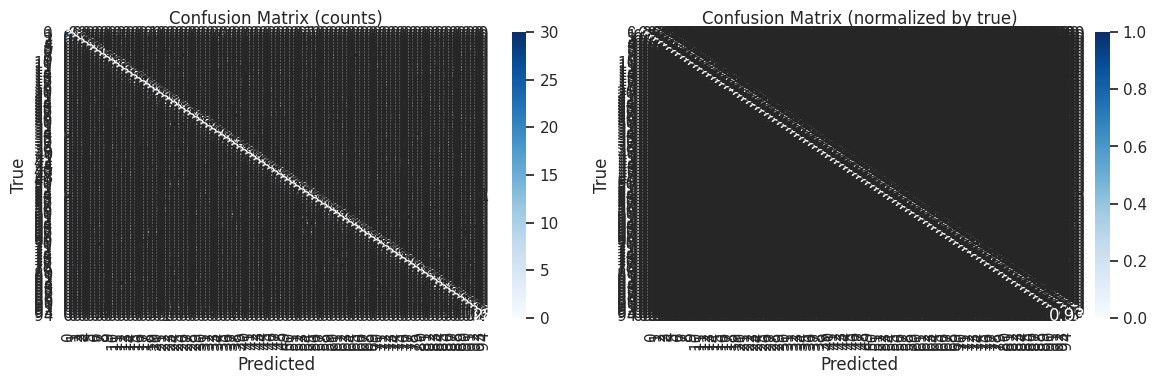

<Figure size 640x480 with 0 Axes>

In [38]:
cm = show_confusion_matrix(y, y_pred, class_names, model_type)

2. Per-class Accuracy



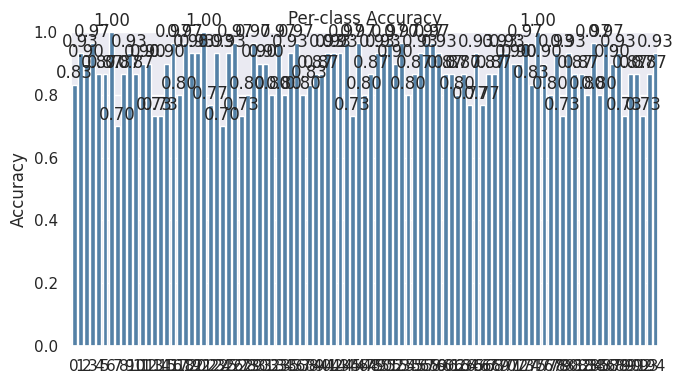

<Figure size 640x480 with 0 Axes>

In [39]:
per_class_accuracy(cm, class_names, model_type)

In [40]:
overall_metrics(y, y_pred, y_prob, n_classes)

3. Overall Metrics

- Accuracy: 0.8811
- Macro F1: 0.8812 (macro P=0.8851, macro R=0.8811)
- Weighted F1: 0.8812 (weighted P=0.8851, weighted R=0.8811)
- Log Loss: 0.6153


In [41]:
top_k_accuracy(y, y_prob, n_classes)

4. Top k Accuracy

- Top-1 accuracy: 0.8811
- Top-3 accuracy: 0.9498
- Top-5 accuracy: 0.9684


In [42]:
##confidence_analysis(y, y_pred, y_prob, model_type)

### Save Model

In [45]:
model.save_model(model=bst_33.best_estimator_, file_name=f"{bst_33.best_params_}")

In [44]:
model.save_model(model=bst_24.best_estimator_, file_name=f"{bst_24.best_params_}")